In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

# Lectura de datos

* La primer columna representa el label o etiqueta de letra al que corresponde el vector de la 1:

In [409]:
df = pd.read_csv('emnist_short.csv')


df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creación de subconjuntos
*
* 7x7
* 10x10
* 15x15

In [410]:
def reshape_img(row, dim):
    """
        Toma el vector de la imagen original (flatten) y lo convierte a una matriz de 28x28
        Usando cv2, se usa esa matriz de 28x28 para convertirla a dimXdim
        Luego, se rota 90 grados
    """
    original = row.values.reshape(28, 28).astype(np.uint8)
    resized = cv2.resize(original, (dim, dim), interpolation=cv2.INTER_AREA)
    resized = np.rot90(resized)
    return resized

In [411]:
def create_subset(df, tamaño, finish_index):
    subset = df.iloc[10:finish_index+1, :]
    return pd.DataFrame({
        'label': subset.iloc[:, 0],
        'image': subset.iloc[:, 1:].apply(lambda row: reshape_img(row, tamaño), axis=1)
    })

finish_index = 13

df_7 = create_subset(df, 7, finish_index)
df_10 = create_subset(df, 10, finish_index)
df_15 = create_subset(df, 15, finish_index)


In [412]:
df_7.head(1)

,label,image
10,15,"[[0, 2, 52, 0, 0, 0, 0], [0, 28, 174, 0, 0, 0,..."


In [413]:
df_10.head(1)

,label,image
10,15,"[[0, 0, 4, 20, 0, 0, 0, 0, 0, 0], [0, 0, 53, 1..."


In [414]:
df_15.head(1)

,label,image
10,15,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]..."


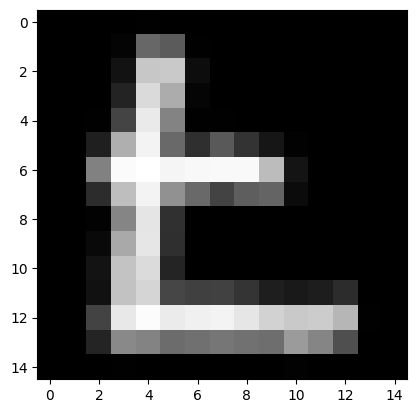

In [415]:
plt.imshow(df_15.iloc[0, 1], cmap='gray')
plt.show()

# Bipolarización de datos (-1, 1)

* Se evalúa cada pixel de la imagen y si es mayor a un thresehold se vuelve 1, de lo contrario -1

In [416]:
def make_bipolar(row, thereshold):
    return np.where(row < thereshold, -1, 1)

dfs = [df_7, df_10, df_15]
bin_dfs = []

for df in dfs:
    df_bin = pd.DataFrame({
        'label': df['label'],
        'image': df['image'].apply(make_bipolar, thereshold=50)
    })
    
    bin_dfs.append(df_bin)

dfb_7, dfb_10, dfb_15 = bin_dfs

In [417]:
dfb_15.head(1)

,label,image
10,15,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


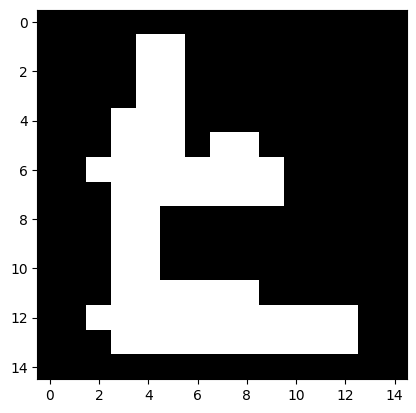

In [418]:
plt.imshow(dfb_15.iloc[0, 1], cmap='gray')
plt.show()

# Red de Hopfield Sincrónica

* Se hacen los cálculos uno por uno

Se usarán los datos a partir del registro 10, de uno en uno para ver en donde comienza a fallar

In [419]:
def train_hopfield(patterns):
    n = patterns.shape[1]
    W = np.zeros((n, n))

    for pattern in patterns:
        W += np.outer(pattern, pattern)

    np.fill_diagonal(W, 0)
    
    return W

In [420]:
weigths = []

for dfb in [dfb_7, dfb_10, dfb_15]:
    # Por cada df, obtenemos su matriz de pesos
    # train_hopfield recibe un arreglo de numpy
    # Este arreglo debe de estar aplanado y dado en una matriz bidimensional
    # Esto apra sacar el número de neuronas igual a las 
    # columnas totales de cada patrón
    dfb['flat'] = dfb['image'].apply(lambda x: np.array(x).flatten())

    patterns = np.stack(dfb['flat'].to_numpy())
    W = train_hopfield(patterns)

    weigths.append(W)

w7, w10, w15 = weigths

In [421]:
dfb_15

,label,image,flat
10,15,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11,13,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
12,24,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
13,12,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [422]:
def sign(x):
    return np.where(x >= 0, 1, -1)
    
def retrieve_hopfield(W, pattern, max_iter=100):

    for i in range(max_iter):
        updated = sign(W @ pattern)
        
        if np.array_equal(updated, pattern):
            break
        
        pattern = updated

    return pattern

In [423]:
def add_noise(pattern, noise_level):
    n = len(pattern)

    num_flips = int(noise_level * n)
    flip_indices = np.random.choice(n, num_flips, replace=False)

    pattern[flip_indices] *= -1

    return pattern

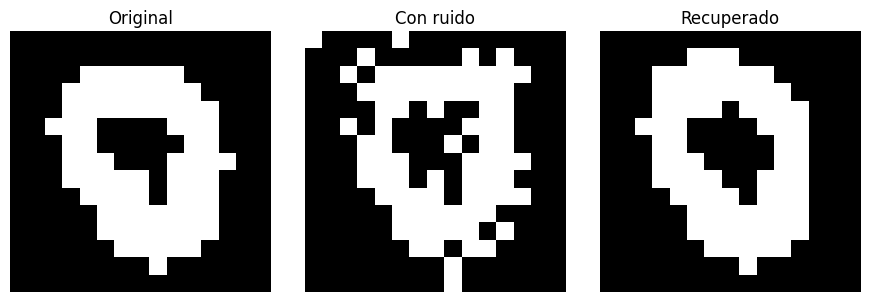

In [424]:
def show_comparison(original_img, noisy_flat, recovered_flat):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    titles = ["Original", "Con ruido", "Recuperado"]
    images = [
        np.array(original_img),
        np.array(noisy_flat).reshape((15, 15)),
        np.array(recovered_flat).reshape((15, 15))
    ]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray", vmin=-1, vmax=1)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

original_img = dfb_15.iloc[2, 1]
original_flat = np.array(dfb_15.iloc[2, 2])
noisy_flat = add_noise(original_flat, noise_level=0.1)
recovered_flat = retrieve_hopfield(W, noisy_flat)

show_comparison(original_img, noisy_flat, recovered_flat)